In [117]:
%matplotlib widget

In [118]:
savefigs = False

import matplotlib.pyplot as plt
plt.rcParams.update({'savefig.bbox': 'tight'})
plt.rcParams.update({'savefig.pad_inches': 0.1})
plt.rcParams.update({'savefig.dpi': 300})

In [119]:
import numpy as np
import meshplot as mp

def vec2(x,y):
    return np.array([x,y], dtype=np.float64)

def is_left(p0, p1, p2):
        return (p1[0] - p0[0]) * (p2[1] - p0[1]) - (p2[0] - p0[0]) * (p1[1] - p0[1])

def compute_signed_distance(poly, q):
    
    def is_left(p0, p1, p2):
        return (p1[0] - p0[0]) * (p2[1] - p0[1]) - (p2[0] - p0[0]) * (p1[1] - p0[1])

    N = poly.shape[0]
    d = np.inf

    # Compute distance to closest surface point
    for i in range(N-1):
        a = poly[i, :]    # Point on the surface of polygon p
        b = poly[i+1, :]  # Adjacent point on the surface of polygon p
        
        ba = b - a     # Vector from a to b
        bal = np.linalg.norm(ba) # Length of ba vector
        if bal == 0:
            continue
        ban = ba / bal # Normal of the vector from a to b
        qa = q - a     # The vector from the query point to a
        alpha = np.dot(qa, ban) / bal
        if alpha < 0:
            da = np.linalg.norm(q-a)
            if da < d:
                d = da
        elif alpha > 1:
            db = np.linalg.norm(q-b)
            if db < d:
                d = db
        else:
            banp = np.array([-ban[1], ban[0]])
            dp = abs(np.dot(qa, banp))
            if dp < d:
                d = dp
    # Compute winding number to set the sign
    wn = 0
    for i in range(N-1):
        a = poly[i, :]    # Point on the surface of polygon p
        b = poly[i+1, :]  # Adjacent point on the surface of polygon p
        if a[1] <= q[1]:
            if b[1] > q[1]:
                if is_left(a, b, q) > 0:
                    wn = wn + 1
        else:
            if b[1] <= q[1]:
                if is_left(a, b, q) < 0:
                    wn = wn -1
    if wn < -0.5:
        d = -d
    elif wn > 0.5:
        d = -d
    return d

def make_beam_mesh(width, height, shape):
    x0 = -width/2.0
    y0 = -height/2.0
    I  = shape[0]
    J  = shape[1]
    dx = width/float(I)
    dy = height/float(J)
    V = np.zeros(((I + 1)*(J + 1), 2), dtype=np.float64)
    for j in range(J + 1):
        for i in range(I + 1):
            k = i + j*(I + 1)
            V[k, 0] = x0 + i*dx
            V[k, 1] = y0 + j*dy
    T = np.zeros((2*I*J,3),dtype=np.int32) 
    for j in range(J):
        for i in range(I):
            k00 = (i    ) + (j    )*(I + 1)
            k01 = (i + 1) + (j    )*(I + 1)
            k10 = (i    ) + (j + 1)*(I + 1)
            k11 = (i + 1) + (j + 1)*(I + 1)
            e = 2*(i + j*I)
            if (i + j)%2:
                T[e    , :] = (k00, k01, k11)
                T[e + 1, :] = (k00, k11, k10)
            else:
                T[e    , :] = (k10, k00, k01)
                T[e + 1, :] = (k10, k01, k11)                    
    return V, T

In [120]:
class SimpleGrid2D:
    def __init__(self, min_coord, max_coord, I, J):
        if np.any(min_coord > max_coord):
            raise ValueError()
        if I < 2:
            raise ValueError()
        if J < 2:
            raise ValueError()

        self.min_coord = min_coord
        self.max_coord = max_coord
        
        self.I = I  # Number of nodes along x axis
        self.J = J  # Number of nodes along y axis
        
        res = np.array([I-1, J-1], dtype=np.float64)
        dims = (self.max_coord - self.min_coord)
        self.spacing = np.divide(dims, res)
        
        self.dx = self.spacing[0]
        self.dy = self.spacing[1]

        self.x = np.linspace(min_coord[0], max_coord[0], I)
        self.y = np.linspace(min_coord[1], max_coord[1], J)
    
        X, Y = np.meshgrid(self.x, self.y)
        self.X = X.T
        self.Y = Y.T
        self.values = np.zeros((I, J), dtype=np.float64)
        
    def interpolate(self, p):
        idx = np.floor((p - self.min_coord) / self.spacing)
        # if index is outside the cells then project onto closest cell
        i = np.clip(int(idx[0]), 0, self.I-2)
        j = np.clip(int(idx[1]), 0, self.J-2)
                
        x00 = self.values[i,j]
        x01 = self.values[i+1,j]
        x10 = self.values[i,j+1]
        x11 = self.values[i+1,j+1]
        
        s = (p[0]  - (i * self.spacing[0] + self.min_coord[0]) ) / self.spacing[0]
        t = (p[1]  - (j * self.spacing[1] + self.min_coord[1])) / self.spacing[1]        

        y0 = (x01 - x00) * s + x00
        y1 = (x11 - x10) * s + x10
        return (y1 - y0) * t + y0
    
    def eval_func(self, func):
        for i in range(self.I):
            for j in range(self.J):
                x = self.X[i,j]
                y = self.Y[i,j]
                self.values[i,j] = func(np.array([x, y]))
    
    def show(grid):
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.set_title('Grid Values')
        plt.imshow(grid.values.T, origin='lower', extent=[grid.min_coord[0], grid.max_coord[0], grid.min_coord[1], grid.max_coord[1]])
        ax.set_aspect('equal')
        plt.colorbar(orientation='vertical')
        plt.show()

def calculate_stencil(points, grid):
        p0, p1, p2 = points
        bool0 = grid.interpolate(p0) < 0
        bool1 = grid.interpolate(p1) < 0
        bool2 = grid.interpolate(p2) < 0
        stencil = bool0 * 2**0 + bool1 * 2**1 + bool2 * 2**2
        return stencil

def find_intersection(p0, p1, grid):
    val0 = grid.interpolate(p0)
    val1 = grid.interpolate(p1)
    grad = (val1 - val0)/np.linalg.norm(p1 - p0)
    intersection = p0 + np.abs(val0/grad) * (p1 - p0)/np.linalg.norm(p1 - p0)
    return intersection

def permute(points, stencil, reverse = False):
    r = 1 if reverse else -1
    # CASE 0
    if stencil == 0:
        points_permuted = points
    # CASE 1
    elif stencil == 1:
        points_permuted = points
    # CASE 2
    elif stencil == 2:
        points_permuted = np.roll(points, 1 * r, axis=0)
    # CASE 3
    elif stencil == 3:
        points_permuted = points
    # CASE 4
    elif stencil == 4:
        points_permuted = np.roll(points, -1 * r, axis=0)
    # CASE 5
    elif stencil == 5:
        points_permuted = np.roll(points, -1 * r, axis=0)
    # CASE 6
    elif stencil == 6:
        points_permuted = np.roll(points, 1 * r, axis=0)
    # CASE 7
    elif stencil == 7:
        points_permuted = points
    return points_permuted

In [121]:
def one_inside_intersections(points, grid):
    p0, p_out1, p_out2 = points
    intersection1 = find_intersection(p0, p_out1, grid)
    intersection2 = find_intersection(p0, p_out2, grid)
    return p0, intersection1, intersection2

def one_inside_new_points(points, stencil, grid):
    points_permuted = permute(points, stencil, reverse=False)
    new_points = one_inside_intersections(points_permuted, grid)
    new_points_permuted = permute(new_points, stencil, reverse=True)
    return new_points_permuted

def one_inside_rule(vertex_array, triangle_index_array, points, triangle_index_set, stencil, grid):
    new_points = one_inside_new_points(points, stencil, grid)
    vertex_array[triangle_index_set] = new_points
    triangle_index_array = np.append(triangle_index_array, [triangle_index_set], axis=0)
    return vertex_array, triangle_index_array

In [122]:
def two_inside_intersections(points, grid):
    p0, p1, p_out = points
    intersection0 = find_intersection(p0, p_out, grid)
    intersection1 = find_intersection(p1, p_out, grid)
    return p0, p1, intersection0, intersection1

def two_inside_new_points(points, stencil, grid):
    points_permuted = permute(points, stencil, reverse=False)
    new_points = two_inside_intersections(points_permuted, grid)
    new_points_permuted = np.array([*permute(new_points[:3], stencil, reverse=True), new_points[3]])
    return new_points_permuted

def two_inside_rule(vertex_array, triangle_index_array, points, triangle_index_set, stencil, grid):
    new_points = two_inside_new_points(points, stencil, grid)
    
    vertex_array[triangle_index_set] = new_points[:3]
    # vertex_array = np.append(vertex_array, [new_points[3]], axis=0)
    
    # triangle_index_set_new = np.array([triangle_index_set[1], len(vertex_array) - 1, triangle_index_set[2]])
    triangle_index_array = np.append(triangle_index_array, [triangle_index_set], axis=0)
    # triangle_index_array = np.append(triangle_index_array, [triangle_index_set_new], axis=0)

    return vertex_array, triangle_index_array

In [123]:
def apply_color_rule(stencil):
    color = 'black'
    if stencil == 0:
        color = 'white'
    elif stencil == 1:
        color = 'blue'
    elif stencil == 2:
        color = 'blue'
    elif stencil == 3:
        color = 'red'
    elif stencil == 4:
        color = 'blue'
    elif stencil == 5:
        color = 'red'
    elif stencil == 6:
        color = 'red'
    return color

def apply_rule(vertex_array, triangle_index_array, points, triangle_index_set, stencil, grid):
    if stencil == 0:
        # No points inside
        vertex_array, triangle_index_array = vertex_array, triangle_index_array
    elif stencil == 1:
        # One point inside
        vertex_array, triangle_index_array = one_inside_rule(vertex_array, triangle_index_array, points, triangle_index_set, stencil, grid)
    elif stencil == 2:
        # One point inside
        vertex_array, triangle_index_array = one_inside_rule(vertex_array, triangle_index_array, points, triangle_index_set, stencil, grid)
    elif stencil == 3:
        # Two points inside
        vertex_array, triangle_index_array = two_inside_rule(vertex_array, triangle_index_array, points, triangle_index_set, stencil, grid)
    elif stencil == 4:
        # One point inside
        vertex_array, triangle_index_array = one_inside_rule(vertex_array, triangle_index_array, points, triangle_index_set, stencil, grid)
    elif stencil == 5:
        # Two points inside
        vertex_array, triangle_index_array = two_inside_rule(vertex_array, triangle_index_array, points, triangle_index_set, stencil, grid)
    elif stencil == 6:
        # Two points inside
        vertex_array, triangle_index_array = two_inside_rule(vertex_array, triangle_index_array, points, triangle_index_set, stencil, grid)
    elif stencil == 7:
        # All points inside
        triangle_index_array = np.append(triangle_index_array, triangle_index_set)
    triangle_index_array = triangle_index_array.reshape(-1, 3)
    return vertex_array, triangle_index_array

In [124]:
def marching_triangles(mesh, grid):
    V, T = mesh
    vertex_array = V.copy()
    triangle_index_array = np.array([], dtype=np.int32)
    for triangle_index_set in T:
        points = V[triangle_index_set]
        
        stencil = calculate_stencil(points, grid)
        vertex_array, triangle_index_array = apply_rule(vertex_array, triangle_index_array, points, triangle_index_set, stencil, grid)
    return vertex_array, triangle_index_array

def make_mt_mesh(poly, I, J):
    min_coord = vec2(min(poly[:,0]), min(poly[:,1]))*1.2
    max_coord = vec2(max(poly[:,0]), max(poly[:,1]))*1.2
    width = (max_coord[0] - min_coord[0])
    height = (max_coord[1] - min_coord[1])
    V, T = make_beam_mesh(width, height, (I, J))
    grid = SimpleGrid2D(min_coord, max_coord, I, J)
    grid.eval_func(lambda p: compute_signed_distance(poly, p))


    ##### RUN THE MARCHING TRIANGLES ALGORITHM #####
    vertex_array, triangle_index_array = marching_triangles((V, T), grid, poly, (I, J))
    return vertex_array, triangle_index_array

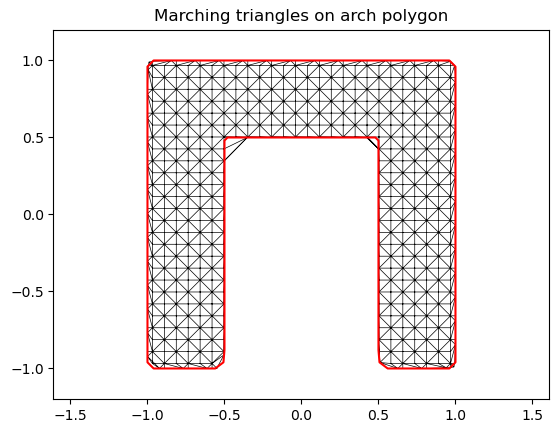

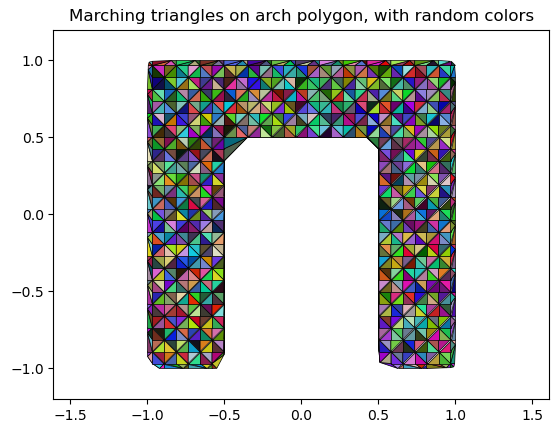

In [154]:
#### DEFINE THE POLYGON, THE MESH AND THE GRID ON WHICH TO PERFORM THE MARCHING TRIANGLES ALGORITHM####
poly = np.zeros((9,2),dtype=np.float64)
poly[0,:] = vec2(-1.0,-1.0)
poly[1,:] = vec2(-0.5,-1)
poly[2,:] = vec2(-0.5,0.5)
poly[3,:] = vec2(0.5,0.5)
poly[4,:] = vec2(0.5,-1)
poly[5,:] = vec2( 1.0,-1.0)
poly[6,:] = vec2( 1.0, 1.0)
poly[7,:] = vec2(-1.0, 1.0)
poly[8,:] = vec2(-1.0,-1.0)

min_coord = vec2(min(poly[:,0]), min(poly[:,1]))*1.2
max_coord = vec2(max(poly[:,0]), max(poly[:,1]))*1.2
width = (max_coord[0] - min_coord[0])
height = (max_coord[1] - min_coord[1])
I = J = 31
V, T = make_beam_mesh(width, height, (I, J))
grid = SimpleGrid2D(min_coord, max_coord, I, J)
grid.eval_func(lambda p: compute_signed_distance(poly, p))


##### RUN THE MARCHING TRIANGLES ALGORITHM #####
vertex_array, triangle_index_array = marching_triangles((V, T), grid)
fig = plt.figure()

### Code that plots the triangles and the contour (FASTER)
plt.contour(grid.X, grid.Y, grid.values, levels=[0], colors='red', alpha=1.0)
plt.triplot(vertex_array[:,0], vertex_array[:,1], triangle_index_array, lw = 0.5, color='black')

plt.axis('equal')
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
plt.title('Marching triangles on arch polygon')

if savefigs:
    fig.savefig('marching_triangles_arch.png')

fig = plt.figure()
### Code that plots the triangles filled with random colors
for i, t in enumerate(triangle_index_array):
    rcolor = np.array([*np.random.rand(3)])
    vertices = vertex_array[t]
    plt.fill(vertices[:,0], vertices[:,1], color=rcolor, edgecolor='black', lw=0.5)


plt.axis('equal')
plt.xlim(-1.2,1.2)
plt.ylim(-1.2,1.2)
plt.title('Marching triangles on arch polygon, with random colors')
if savefigs:
    fig.savefig('marching_triangles_arch_colors.png')

In [126]:
# #### DEFINE A NEW POLYGON, THE MESH AND THE GRID ON WHICH TO PERFORM THE MARCHING TRIANGLES ALGORITHM####
# legs = 4
# points = 2*legs + 1

# poly = np.zeros((points,2),dtype=np.float64)
# for i in range(points):
#     r = 1
#     if (i + 1) % 2 == 0:
#         r = 1/3
#     poly[i] = r * vec2(np.sin(2*np.pi*i/(points-1)), np.cos(2*np.pi*i/(points-1)))

# min_coord = vec2(min(poly[:,0]), min(poly[:,1]))*1.2
# max_coord = vec2(max(poly[:,0]), max(poly[:,1]))*1.2
# width = (max_coord[0] - min_coord[0])
# height = (max_coord[1] - min_coord[1])
# I = J = 59
# V, T = make_beam_mesh(width, height, (I, J))
# grid = SimpleGrid2D(min_coord, max_coord, I, J)
# grid.eval_func(lambda p: compute_signed_distance(poly, p))


# ##### RUN THE MARCHING TRIANGLES ALGORITHM #####
# vertex_array, triangle_index_array = marching_triangles((V, T), grid)
# fig = plt.figure()
# plt.contour(grid.X, grid.Y, grid.values, levels=[0], colors='red', lw = 0.5, alpha=0.5, linestyles='dashed')
# plt.triplot(vertex_array[:,0], vertex_array[:,1], triangle_index_array, lw = 0.5, color='black')

# plt.axis('equal')
# if savefigs:
#     fig.savefig('marching_triangles_star.png', dpi = 300)

In [127]:
# #### DEFINE A NEW POLYGON, THE MESH AND THE GRID ON WHICH TO PERFORM THE MARCHING TRIANGLES ALGORITHM####
# legs = 5
# points = 2*legs + 1

# poly = np.zeros((points,2),dtype=np.float64)
# for i in range(points):
#     r = 1
#     if (i + 1) % 2 == 0:
#         r = 1/3
#     poly[i] = r * vec2(np.sin(2*np.pi*i/(points-1)), np.cos(2*np.pi*i/(points-1)))

# min_coord = vec2(min(poly[:,0]), min(poly[:,1]))*1.2
# max_coord = vec2(max(poly[:,0]), max(poly[:,1]))*1.2
# width = (max_coord[0] - min_coord[0])
# height = (max_coord[1] - min_coord[1])
# I = J = 101
# V, T = make_beam_mesh(width, height, (I, J))
# grid = SimpleGrid2D(min_coord, max_coord, I, J)
# grid.eval_func(lambda p: compute_signed_distance(poly, p))


# ##### RUN THE MARCHING TRIANGLES ALGORITHM #####
# vertex_array, triangle_index_array = marching_triangles((V, T), grid)
# fig = plt.figure()
# plt.contour(grid.X, grid.Y, grid.values, levels=[0], colors='red', lw = 0.5, alpha=0.5, linestyles='dashed')
# plt.triplot(vertex_array[:,0], vertex_array[:,1], triangle_index_array, lw = 0.5, color='black')

# plt.axis('equal')
# if savefigs:
#     fig.savefig('marching_triangles_5star.png', dpi = 300)

In [128]:
# #### PLOT ORIGINAL TRIANGLES COLORED BY STENCIL ####
# fig = plt.figure()

# triangle_index_array = np.array([], dtype=np.int32)
# colors_array = np.array([], dtype=np.str0)
# for i, t in enumerate(T):
#     i0, i1, i2 = t
#     p0, p1, p2 = V[i0], V[i1], V[i2]
    
#     stencil = calculate_stencil([p0, p1, p2], grid)
#     color = apply_color_rule(stencil)
#     colors_array = np.append(colors_array, color)
#     plt.fill([p0[0], p1[0], p2[0], p0[0]], [p0[1], p1[1], p2[1], p0[1]], color=color, alpha=0.2)
#     plt.plot([p0[0], p1[0], p2[0], p0[0]], [p0[1], p1[1], p2[1], p0[1]], marker='', ls = '-', lw = 0.1, color='black')

# plt.contour(grid.X, grid.Y, grid.values, levels=[0], colors='black', alpha=1)
# plt.axis('equal')

In [129]:
#### DEFINE THE POLYGON, THE MESH AND THE GRID ON WHICH TO PERFORM THE MARCHING TRIANGLES ALGORITHM####
poly = np.zeros((9,2),dtype=np.float64)
poly[0,:] = vec2(-1.0,-1.0)
poly[1,:] = vec2(-0.5,-1)
poly[2,:] = vec2(-0.5,0.5)
poly[3,:] = vec2(0.5,0.5)
poly[4,:] = vec2(0.5,-1)
poly[5,:] = vec2( 1.0,-1.0)
poly[6,:] = vec2( 1.0, 1.0)
poly[7,:] = vec2(-1.0, 1.0)
poly[8,:] = vec2(-1.0,-1.0)

min_coord = vec2(min(poly[:,0]), min(poly[:,1]))*1.2
max_coord = vec2(max(poly[:,0]), max(poly[:,1]))*1.2
width = (max_coord[0] - min_coord[0])
height = (max_coord[1] - min_coord[1])
I = J = 31
V, T = make_beam_mesh(width, height, (I, J))
grid = SimpleGrid2D(min_coord, max_coord, I, J)
grid.eval_func(lambda p: compute_signed_distance(poly, p))

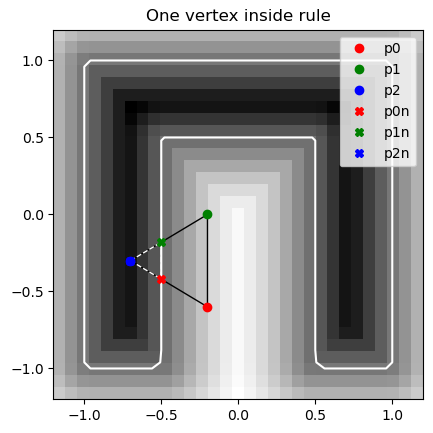

In [130]:
##### TESTING THE ONE INSIDE FUNCTIONS #####
points = np.array([[-0.2, -0.6],
                  [-0.2, 0.0],
                  [-0.7, -0.3]])

fig = plt.figure()
plt.imshow(grid.values.T, extent=[min_coord[0], max_coord[0], min_coord[1], max_coord[1]], origin='lower', cmap='Greys_r')
plt.contour(grid.X, grid.Y, grid.values, levels=[0], colors='white', alpha=1)

plt.plot(*points[0], 'ro', label="p0")
plt.plot(*points[1], 'go', label="p1")
plt.plot(*points[2], 'bo', label="p2")
plt.triplot(points[:,0], points[:,1], [[0, 1, 2]], lw = 1.0, color='black')

#Returns 1 if inside or 0 if outside for each of the three vertices
stencil = calculate_stencil(points, grid)
new_points_permuted = one_inside_new_points(points, stencil, grid)
p0n, p1n, p2n = new_points_permuted

plt.plot(*p0n, 'rX', label="p0n")
plt.plot(*p1n, 'gX', label="p1n")
plt.plot(*p2n, 'bX', label="p2n")
plt.triplot(new_points_permuted[:,0], new_points_permuted[:,1], [[0, 1, 2]], lw = 1.0, linestyle='--', color='white')

plt.title("One vertex inside rule")
plt.legend()
plt.show()
if savefigs:
    fig.savefig('one_inside_rule.png', dpi = 300)

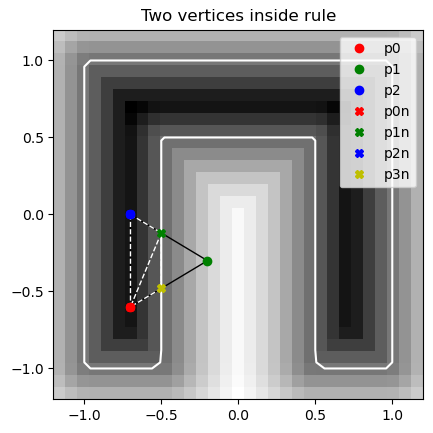

In [131]:
##### TESTING THE TWO INSIDE FUNCTIONS #####
points = np.array([[-0.7, -0.6],
                   [-0.2, -0.3],
                   [-0.7, 0.0]])

fig = plt.figure()
plt.imshow(grid.values.T, extent=[min_coord[0], max_coord[0], min_coord[1], max_coord[1]], origin='lower', cmap='Greys_r')
plt.contour(grid.X, grid.Y, grid.values, levels=[0], colors='white', alpha=1)

plt.plot(*points[0], 'ro', label="p0")
plt.plot(*points[1], 'go', label="p1")
plt.plot(*points[2], 'bo', label="p2")
plt.triplot(points[:,0], points[:,1], [[0, 1, 2]], lw = 1.0, color='black')

#Returns 1 if inside or 0 if outside for each of the three vertices
stencil = calculate_stencil(points, grid)

new_points = two_inside_new_points(points, stencil, grid)
p0n, p1n, p2n, p3n = new_points
Vn = np.array([p0n, p1n, p2n, p3n])
Tn = np.array([[0,1,2], [0,3,1]])

plt.plot(*p0n, 'rX', label="p0n")
plt.plot(*p1n, 'gX', label="p1n")
plt.plot(*p2n, 'bX', label="p2n")
plt.plot(*p3n, 'yX', label="p3n")
plt.triplot(Vn[:,0], Vn[:,1], Tn, lw = 1.0, linestyle='--', color='white')

plt.title("Two vertices inside rule")

plt.legend()
plt.show()

if savefigs:
    fig.savefig('two_inside_rule.png', dpi = 300)